In [38]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import glob

from PIL import Image

print("import successful!")

import successful!


In [93]:
# set the hyperparameters
lr = 0.0001
batch_size = 32
epochs = 30

In [94]:
# set seed and random value
device = "cuda" if torch.cuda.is_available() else "cpu"

In [95]:
# get the directory
base_dir = "C:/Users/user/Desktop/MIT 400/MACHINE LEARNING/Tumor-1/Tumor/"

train_dir = "train"
test_dir = "test"

In [96]:
# get the train and test list
train_list = glob.glob(os.path.join(base_dir, train_dir, "*.jpg"))
test_list = glob.glob(os.path.join(base_dir, test_dir, "*.jpg"))

In [97]:
# check the list of dataset in the train
len(train_list), len(test_list)

(188, 20)

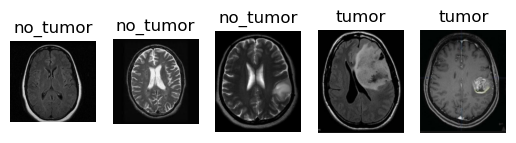

In [98]:
#check the databse
random_idx = np.random.randint(1, 188, size=5)

fig = plt.figure()
i = 1
for idx in random_idx:
    ax = fig.add_subplot(2, 5, i)
    img = Image.open(train_list[idx])
    ax.imshow(img)
    ax.set_title(train_list[idx].split('/')[-1].split(".")[0].split("\\")[1])
    ax.axis("off")
    i += 1
    
plt.show()

In [99]:
train_list[0].split('/')[-1].split(".")[0].split("\\")[-1]

'no_tumor'

In [100]:
#Augment the data
train_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((128, 128)),
    transforms.RandomResizedCrop(128),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

test_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((128, 128)),
    transforms.RandomResizedCrop(128),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

In [101]:
# Load data
class dataset(torch.utils.data.Dataset):
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform
        
#dataset length
    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength
    
#Load one of the images
    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img)
        
        label = img_path.split('/')[-1].split(".")[0].split("\\")[-1]
        if label == "tumor":
            label = 0
        elif label == "no_tumor":
            label = 1
            
        return img_transformed, label

In [102]:
# get the dataset loaded
train_data = dataset(train_list, transform=train_transforms)
test_data = dataset(test_list, transform=test_transforms)

In [103]:
#use the dataloader to load all the images
train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size=batch_size, shuffle=True)

In [104]:
#get the len
print(len(train_data), len(test_data))

188 20


In [105]:
#check the image
train_data[0][0].shape

torch.Size([3, 128, 128])

In [106]:
#build model
class Cnn(nn.Module):
    def __init__(self):
        super(Cnn,self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(3,16, kernel_size=3, padding=0,stride=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2)
    )
    
        self.layer2 = nn.Sequential(
            nn.Conv2d(16,32, kernel_size=3, padding=0,stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
    
        self.layer3 = nn.Sequential(
            nn.Conv2d(32,64, kernel_size=3, padding=0,stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.fc1 = nn.Linear(64*1*1,10)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(10,2)
        self.relu = nn.ReLU()
        
    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0),-1)
        out = self.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [107]:
model = Cnn().to(device)
model.train()

Cnn(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=10, out_features=2, bias=True)
  (rel

In [108]:
#set loss funtion and optimizer
optimizer = optim.Adam(params = model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

In [109]:
#train the network
epochs = 30
count = 0
loss_list = []
accuracy_list = []
iteration_list = []

for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy  = 0
    
    for data, label in train_loader:
        data = data.to(device)
        
        output = model(data)
        loss = criterion(output, label)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        acc = ((output.argmax(dim=1) == label).float().mean())
        epoch_accuracy += acc/len(train_loader)
        epoch_loss += loss/len(train_loader)
        
    count+=1
    accuracy_list.append(epoch_accuracy)
    loss_list.append(epoch_loss)
    iteration_list.append(count)
    
    print('Epoch : {}, train accuracy : {}, train loss : {}'.format(epoch+1, epoch_accuracy,epoch_loss))

Epoch : 1, train accuracy : 0.515625, train loss : 0.696648359298706
Epoch : 2, train accuracy : 0.5171130895614624, train loss : 0.6954723596572876
Epoch : 3, train accuracy : 0.5133928656578064, train loss : 0.6905762553215027
Epoch : 4, train accuracy : 0.5141369104385376, train loss : 0.6871707439422607
Epoch : 5, train accuracy : 0.5171130895614624, train loss : 0.6846563220024109
Epoch : 6, train accuracy : 0.5245535969734192, train loss : 0.683270275592804
Epoch : 7, train accuracy : 0.5126487612724304, train loss : 0.6808664202690125
Epoch : 8, train accuracy : 0.5171130895614624, train loss : 0.6706861853599548
Epoch : 9, train accuracy : 0.515625, train loss : 0.6752391457557678
Epoch : 10, train accuracy : 0.5215774178504944, train loss : 0.6726804971694946
Epoch : 11, train accuracy : 0.5252976417541504, train loss : 0.6722962856292725
Epoch : 12, train accuracy : 0.5089285373687744, train loss : 0.6774119734764099
Epoch : 13, train accuracy : 0.53125, train loss : 0.669376

In [110]:
len(iteration_list)
new_loss_list = []
new_accuracy_list = []

for i in range(len(iteration_list)):
    new_loss_list.append(loss_list[i].detach().numpy())
    new_accuracy_list.append(accuracy_list[i].detach().numpy())

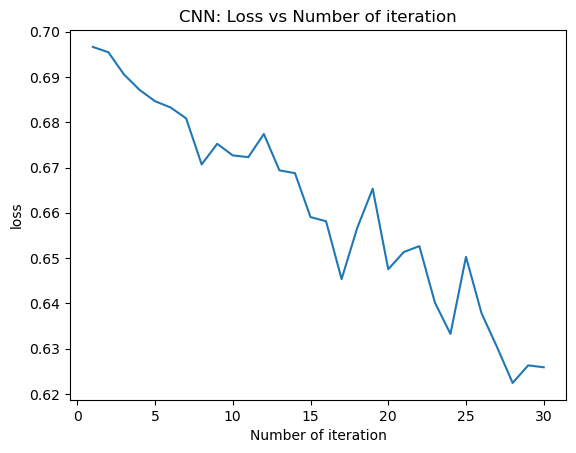

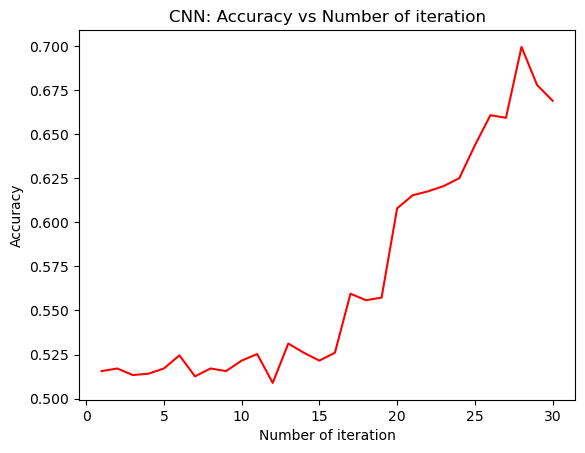

In [111]:
#visualization loss
plt.plot(iteration_list,new_loss_list)
plt.xlabel("Number of iteration")
plt.ylabel("loss")
plt.title("CNN: Loss vs Number of iteration")
plt.show()

#visualization Accuracy
plt.plot(iteration_list, new_accuracy_list, color = "red")
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("CNN: Accuracy vs Number of iteration")
plt.show()

In [112]:
tumor_probs = []
model.eval()
with torch.no_grad():
    for data, fileid in test_loader:
        data = data.to(device)
        preds = model(data)
        preds_list = F.softmax(preds, dim=1)[:, 1].tolist()
        tumor_probs+= list(zip(list(fileid), preds_list))

In [113]:
tumor_probs.sort(key = lambda x : int(x[0]))
tumor_probs

[('21', 0.39081668853759766),
 ('22', 0.3262673318386078),
 ('23', 0.313531756401062),
 ('24', 0.624057948589325),
 ('25', 0.4853752851486206),
 ('26', 0.5005736947059631),
 ('27', 0.16513872146606445),
 ('28', 0.26229867339134216),
 ('29', 0.27926886081695557),
 ('30', 0.44469863176345825),
 ('33', 0.5584046244621277),
 ('34', 0.48091763257980347),
 ('35', 0.6196398735046387),
 ('36', 0.5448574423789978),
 ('37', 0.46230748295783997),
 ('38', 0.5753980875015259),
 ('39', 0.5777103304862976),
 ('40', 0.6753000020980835),
 ('55', 0.5381016135215759),
 ('58', 0.46984896063804626)]

In [114]:
idx = list(map(lambda x: x[0], tumor_probs))
prob = list(map(lambda x: x[1], tumor_probs))

In [115]:
submission = pd.DataFrame({'id':idx, 'label':prob})
submission

,id,label
0,21,0.390817
1,22,0.326267
2,23,0.313532
3,24,0.624058
4,25,0.485375
5,26,0.500574
6,27,0.165139
7,28,0.262299
8,29,0.279269
9,30,0.444699


In [116]:
#save the result as a cvs file
submission.to_csv('result.csv', index=False)

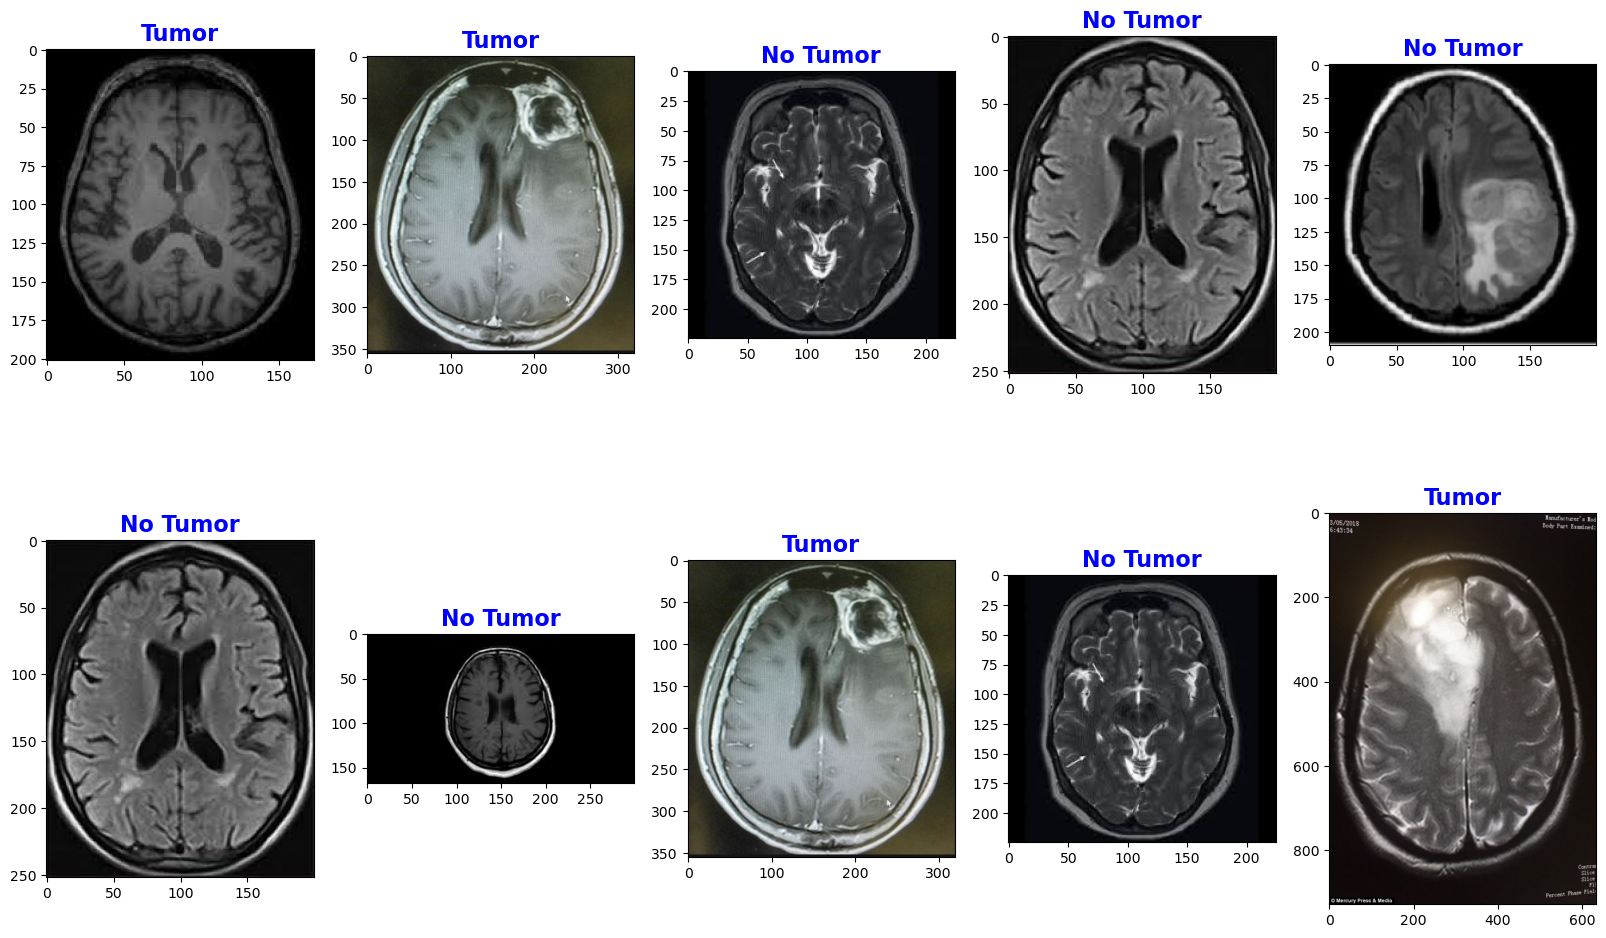

In [118]:
import random

id_list = []
class_= {0: 'Tumor', 1: 'No Tumor'}

fig, axes = plt.subplots(2, 5, figsize=(20, 12), facecolor='w')

for ax in axes.ravel():
    
    i= random.choice(submission['id'].values)
    
    label = submission.loc[submission['id'] ==i, 'label'].values[0]
    if label > 0.5:
        label = 1
    else:
        label = 0
        
    img_path = os.path.join(base_dir, test_dir, '{}.jpg'.format(i))
    img = Image.open(img_path)
    
    ax.set_title(class_[label], color = 'blue', weight='bold', fontsize=16)
    ax.imshow(img)